In [1]:
import os
import re
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers
from keras import Model
from keras import applications
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [2]:
# seems to reduce the chance of gpu errors

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [3]:
batch_size = 64

In [ ]:
def read_pil_image(img_path):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((32, 32)))

def load_all_images(dataset_path, img_ext='png'):
    return np.array([read_pil_image(str(p), 32, 32) for p in Path(dataset_path).rglob("*."+img_ext)]) 

In [3]:
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.2)

if os.path.isdir('preview'):
    shutil.rmtree('preview')
os.makedirs('preview')
img = load_img('data/train/cat/204.png')
x = img_to_array(img)          # array with shape (3, 32, 32)
x = x.reshape((1,) + x.shape)  # array with shape (1, 3, 32, 32)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='png'):
    i += 1
    if i > 20:
        break

In [11]:
datagen_aug = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2, 
                                 horizontal_flip=True,
                                 width_shift_range=3,
                                 height_shift_range=3)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#datagen.fit(load_all_images('./data/train', height, width))


train_generator = datagen_aug.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='training')

validation_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [15]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('softmax'))

opt = optimizers.Adam(lr = 0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
history = model.fit_generator(train_generator,
                              epochs=1,
                              workers=2, # weirdly enough 3 works best (training on 6c/12t)
                              validation_data=validation_generator,
                              steps_per_epoch=40000 // batch_size,
                              validation_steps=10000 // batch_size)

Epoch 1/1
625/625 [==============================] - 23s 37ms/step - loss: 0.0622 - accuracy: 0.9803 - val_loss: 0.7235 - val_accuracy: 0.8703


In [3]:
# save_bottlebeck_features
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

model = applications.densenet.DenseNet201(input_shape=(32,32,3), include_top=False, weights='imagenet')

t_generator = datagen.flow_from_directory('data/train',
                                           subset='training',
                                           seed=0,
                                           shuffle=False,
                                           class_mode=None,
                                           target_size=(32, 32),
                                           batch_size=40000)
with tf.device('/cpu:0'):
    bottleneck_features_train = model.predict_generator(t_generator, 1)
np.save('bottleneck_features_train.npy', bottleneck_features_train)

v_generator = datagen.flow_from_directory('data/train',
                                           subset='validation',
                                           seed=0,
                                           shuffle=False,
                                           class_mode=None,
                                           target_size=(32, 32),
                                           batch_size=10000)
with tf.device('/cpu:0'):
    bottleneck_features_validation = model.predict_generator(v_generator, 1)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [ ]:
# train_top_model
train_data = np.load('bottleneck_features_train.npy')
l = []
for i in range(10):
    l = l + [i] * 4000
train_labels = to_categorical(np.array(l), num_classes=10)
    
validation_data = np.load('bottleneck_features_validation.npy')
l = []
for i in range(10):
    l = l + [i] * 1000
validation_labels = to_categorical(np.array(l), num_classes=10)

model = Sequential()
model.add(Flatten(input_shape=(train_data.shape[1:])))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, 
                    train_labels,
                    epochs=16,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))

In [11]:
model.save_weights('top_layer_model.h5')

In [30]:
history.history['val_accuracy'][-16:]

[0.8702924847602844]

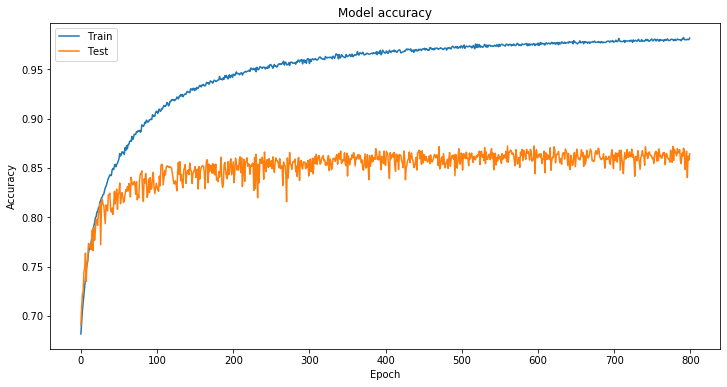

In [26]:
f = plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig('86.44_5h_batch64(aug_hflip,shift3)_epoch800_[cnv_32x2_64x2]_dns[256]_(batch_normalization).svg', bbox_inches='tight')

In [31]:
model.save_weights('87.03_5h_batch64(aug_hflip,shift3)_epoch800+2_[cnv_32x2_64x2]_dns[256]_(batch_normalization).h5')

In [42]:
model.load_weights('87.03_5h_batch64(aug_hflip,shift3)_epoch800+2_[cnv_32x2_64x2]_dns[256]_(batch_normalization).h5')

In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test',
                                                   target_size=(32, 32),
                                                   batch_size=128,
                                                   shuffle=False)

Found 300000 images belonging to 1 classes.


In [44]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

2344/2344 [==============================] - 82s 35ms/step


In [45]:
indices = np.argmax(pred, axis=1)
ids = [int(re.sub('\D+', '', name)) for name in test_generator.filenames]
flipped = {v:k for k,v in validation_generator.class_indices.items()}
labels = [flipped[i] for i in indices]
submission = pd.DataFrame({'id':ids, 'label':labels}).sort_values(['id']).reset_index(drop=True)

In [46]:
submission.to_csv('submission.csv', index=False)

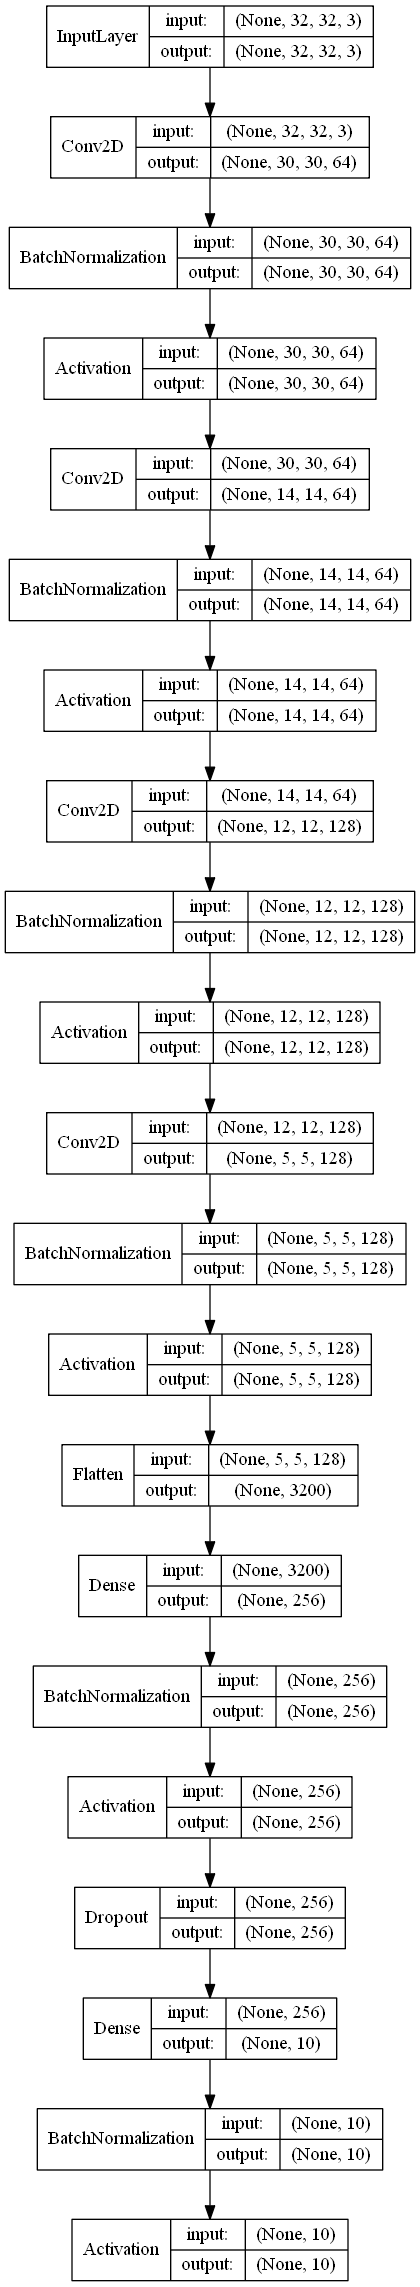

In [41]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_layer_names=False, show_shapes=True)